### Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import seaborn as sns

Set path, will need to change for your system;
You need to have an environment variable named HOME where the whole project is located

In [4]:
path = os.path.expandvars("../src/data/")

Read in BTC and FED data

In [5]:
BTC = pd.read_csv(path + "BTC-USD.csv")
BTC['Date'] = pd.to_datetime(BTC['Date'], format='%Y/%m/%d') #formats the date.
BTC = BTC.set_index('Date',drop=True) #makes the date the index for dataframe


FED = pd.read_csv(path + "FED_rate.csv")
FED['DATE'] = pd.to_datetime(FED['DATE'], format='%d/%m/%Y')
FED = FED.set_index('DATE',drop=True)

## Useful Functions
These will be used in the analysis.

- Functions to get the values of data before and after a particular date. 

In [6]:
def before(data,date,period):
    ind = data.index.get_loc(date)
    
    start = max(0,ind-period)
    
    return(data.iloc[start:ind]) #period before the date

def after(data,date,period):
    ind = data.index.get_loc(date)
    
    end = min(len(BTC),ind+period+1)
    
    return(data.iloc[ind:end]) #date given + period after the date

- Moving Average function, this will determine the MA for all dates in dataframe (it won't apply to dates where the time before it is less than the specified period, i.e the first date in the data will not have an MA)

In [7]:
def MA(data,colname,period):
    data['MA_'+str(period)] = 0
    for ind in range(period-1,len(data)):
        start = ind - period + 1
        end = ind
        
        data['MA_'+str(period)].iloc[ind] = np.mean(data[colname].iloc[start:end])
    return

- Rolling Volatiltity function, similar to MA above.

In [8]:
def Roll_Var(data,colname,period):
    data['Var_'+str(period)] = 0
    for ind in range(period-1,len(data)):
        start = ind - period + 1
        end = ind
        
        data['Var_'+str(period)].iloc[ind] = np.var(data[colname].iloc[start:end])
    return

## Analysis

Dates where the FED rate chnaged, it will be stored in dates_star

In [10]:
dates_change = []
values_change=[]
values = []

crate = FED.IOER[1]

for i in range(1,len(FED)):
    nrate = FED.IOER[i]
    
    if nrate != crate:
        dates_change.append(FED.index[i])
        values_change.append(nrate-crate)
        values.append(nrate)
        
    crate = nrate
    
    
dates_star = pd.DataFrame({"Dates":dates_change,"New Value":values,"Change":values_change})

In [11]:
dates_star # dates of fed changes and the differnce

,Dates,New Value,Change
0,2016-12-15,0.75,0.25
1,2017-03-16,1.00,0.25
2,2017-06-15,1.25,0.25
3,2017-12-14,1.50,0.25
4,2018-03-22,1.75,0.25
5,2018-06-14,1.95,0.20
6,2018-09-27,2.20,0.25
7,2018-12-20,2.40,0.20
8,2019-05-02,2.35,-0.05
9,2019-08-01,2.10,-0.25


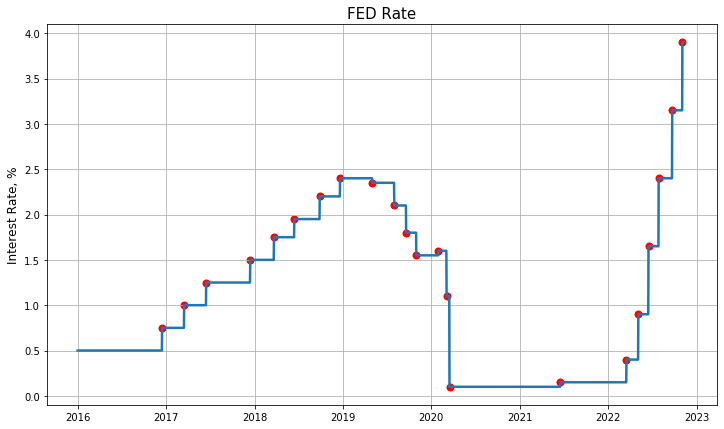

In [21]:
plt.figure(figsize=(12, 7))

plt.scatter(dates_star['Dates'],dates_star['New Value'],color='r',linewidth=2)
plt.plot(FED.IOER,linewidth=2.5)

plt.ylabel('Interest Rate, %',fontsize=12)
plt.grid(True)
plt.title('FED Rate',fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

To start, I will look at relationships between the changes in the FED rate and the n-day change in BTC after the announcment. For example, if the FED rate changed on Monday, I take the closing price on Sunday night than the 0day would just be the difference between the close on monday and the first closing price, the 1day would be the difference between the clsoing price on Tuesday and the closing price on Sunday. (I am measuring the days after the change but the difference taken is one day extra). 

We will check if there is correlation between these changes and the n-day change in BTC. I will check for n=1,2,3,...,7.

In [10]:
CHG_DATES = dates_star.Dates

CHANGE = pd.DataFrame(index=CHG_DATES,columns=['FED_change','0day','1day','2day','3day','4day','5day','6day','7day'])

for d in CHG_DATES:
    btc0 = float(before(BTC['Adj Close'],d,1)) #close day before change
    
    btc1 = after(BTC['Adj Close'],d,7) #closes on each day after the change
    btc1 = btc1.to_numpy()
    
    CHANGE.loc[d,['0day','1day','2day','3day','4day','5day','6day','7day']] = btc1 - btc0
    
    
CHANGE['FED_change'] = list(dates_star.Change)

for col in CHANGE.columns:
    CHANGE[col] = pd.to_numeric(CHANGE[col])

Check correlation, we are only interested in the first row/column. 

In [11]:
CHANGE.corr()

,FED_change,0day,1day,2day,3day,4day,5day,6day,7day
FED_change,1.000000,-0.121775,-0.071150,-0.137565,-0.220316,-0.156568,-0.197437,-0.272994,-0.241836
0day,-0.121775,1.000000,0.839905,0.800050,0.801722,0.741039,0.724519,0.763272,0.729151
1day,-0.071150,0.839905,1.000000,0.960274,0.940703,0.925157,0.875687,0.783426,0.757515
2day,-0.137565,0.800050,0.960274,1.000000,0.935841,0.865569,0.812844,0.719470,0.676462
3day,-0.220316,0.801722,0.940703,0.935841,1.000000,0.960578,0.908720,0.826185,0.801751
4day,-0.156568,0.741039,0.925157,0.865569,0.960578,1.000000,0.965985,0.874655,0.851037
5day,-0.197437,0.724519,0.875687,0.812844,0.908720,0.965985,1.000000,0.956686,0.939305
6day,-0.272994,0.763272,0.783426,0.719470,0.826185,0.874655,0.956686,1.000000,0.975990
7day,-0.241836,0.729151,0.757515,0.676462,0.801751,0.851037,0.939305,0.975990,1.000000


There does not appear to be any signifigant relationships between the FED changes and any of the 0-7 days changes after the FED rate change occurs.
Next I will look at the moving averages.

Add MA for periods of 10, 50 and 100 days

In [35]:
MA(BTC,'Adj Close',10) #Adds the following MAs to do the Dataframe BTC
MA(BTC,'Adj Close',50)
MA(BTC,'Adj Close',100)

C:\Users\Camer\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


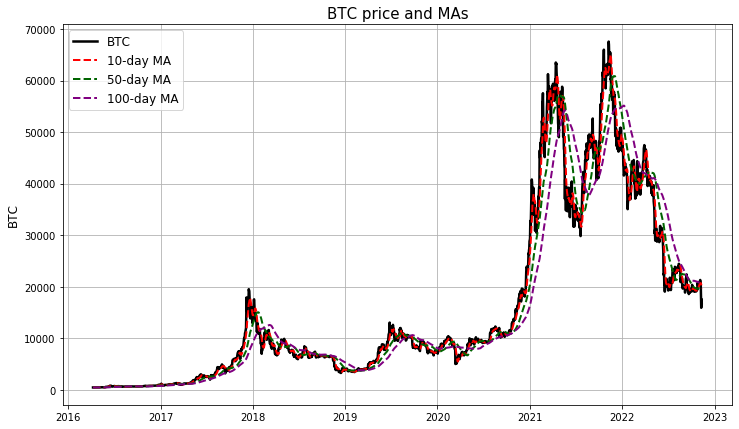

In [36]:
plt.figure(figsize=(12, 7))
plt.plot(BTC['Adj Close'].iloc[99:],linewidth=2.5,color='black')
plt.plot(BTC['MA_10'].iloc[99:],linewidth=2,linestyle='dashed',color='r')
plt.plot(BTC['MA_50'].iloc[99:],linewidth=2,linestyle='dashed',color='darkgreen')
plt.plot(BTC['MA_100'].iloc[99:],linewidth=2,linestyle='dashed',color='purple')

plt.ylabel('BTC',fontsize=12)
plt.grid(True)
plt.title('BTC price and MAs',fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(['BTC','10-day MA','50-day MA','100-day MA'],fontsize=12,loc='upper left')
plt.show()

The above gives a warning but it stil works!

In [37]:
MA10 = BTC['MA_10'][BTC.MA_10>0] #removes the values equal to zero, as these are values that could we cannot get an MA for as
MA50 = BTC['MA_50'][BTC.MA_50>0] # they are at the start of the data.
MA100 = BTC['MA_100'][BTC.MA_100>0]

CI10 = [np.quantile(MA10,0.025),np.quantile(MA10,0.975)] #computes a 95% CI
CI50 = [np.quantile(MA50,0.025),np.quantile(MA50,0.975)]
CI100 = [np.quantile(MA100,0.025),np.quantile(MA100,0.975)]

The following code creates a new dataframe, in which I check if the respectcive MA after each FED rate changes is signifigantly different from the general distribution of the MA for that period.

In [44]:
CHG_DATES = dates_star.Dates
n = len(dates_star)

MA_DATA = pd.DataFrame(index=CHG_DATES,columns=['10MA_after','in CI10','50MA_after','in CI50','100MA_after','in CI100'])

for d in CHG_DATES:
    period10 = after(BTC['Adj Close'],d,10)
    MA_DATA.loc[d,'10MA_after'] = period10.mean()
    if period10.mean() < CI10[1] and period10.mean() > CI10[0]:
        MA_DATA.loc[d,'in CI10'] = 1
    else:
        MA_DATA.loc[d,'in CI10'] = 0
        
    period50 = after(BTC['Adj Close'],d,50)
    MA_DATA.loc[d,'50MA_after'] = period50.mean()
    if period50.mean() < CI50[1] and period50.mean() > CI50[0]:
        MA_DATA.loc[d,'in CI50'] = 1
    else:
        MA_DATA.loc[d,'in CI50'] = 0
        
    period100 = after(BTC['Adj Close'],d,100)
    MA_DATA.loc[d,'100MA_after'] = period100.mean()
    if period100.mean() < CI100[1] and period100.mean() > CI10[0]:
        MA_DATA.loc[d,'in CI100'] = 1
    else:
        MA_DATA.loc[d,'in CI100'] = 0

In [45]:
MA_DATA #1 means that is in the CI and not signif

,10MA_after,in CI10,50MA_after,in CI50,100MA_after,in CI100
Dates,,,,,,
2016-12-15,832.159,1,907.1,1,1007.87,1
2017-03-16,1039.83,1,1182.86,1,1737.59,1
2017-06-15,2621.48,1,2562.62,1,3301.4,1
2017-12-14,16789.5,1,13934.8,1,11728.9,1
2018-03-22,7876.63,1,8304.66,1,7788.05,1
2018-06-14,6510.16,1,6917.66,1,6766.36,1
2018-09-27,6598.83,1,6428.51,1,5190.92,1
2018-12-20,3914.6,1,3714.32,1,3808.29,1
2019-05-02,6108.16,1,7841.82,1,9381.62,1


Dates
2016-12-15      832.159451
2017-03-16     1039.829274
2017-06-15     2621.477273
2017-12-14    16789.481801
2018-03-22     7876.626420
2018-06-14     6510.164551
2018-09-27     6598.830922
2018-12-20     3914.604448
2019-05-02     6108.157848
2019-08-01    11331.135742
2019-09-19     9099.633079
2019-10-31     9188.939275
2020-01-30     9562.928089
2020-03-04     7586.753684
2020-03-16     6039.314764
2021-06-17    34199.676136
2022-03-17    42922.887074
2022-05-05    32015.520952
2022-06-16    20597.125178
2022-07-28    23257.989879
2022-09-22    19233.752841
2022-11-03    19220.870334
Name: 10MA_after, dtype: float64

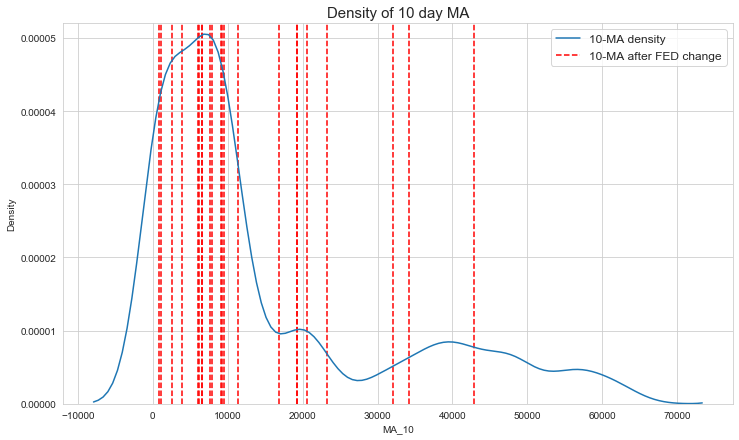

In [72]:
plt.figure(figsize=(12, 7))
sns.set_style('whitegrid')
sns.distplot(MA10, hist=False,label='10-MA density')
plt.vlines(pd.to_numeric(MA_DATA['10MA_after']),ymin=0,ymax=0.000052,color='r',linewidth=1.5,linestyle='dashed',
          label = '10-MA after FED change')

plt.legend(fontsize=12,loc='upper right')
plt.ylim(0,0.000052)

plt.grid(True)
plt.title('Density of 10 day MA',fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.ylabel('Density')

plt.show()

The above is not exactly a great way to check such a relationship, the idea is to check if after one of these FED changes happens, does the MA over a certain period differ signifigantly from its usual range? We see in the above, this does not occur, we could possibly lower the confidence level, since the MA is going to be a very smooth curve and it would unlikely to expect large jumps in it

Since BTC has changed a lot over the years, the distribution of the MA is going to have fat tails and this makes it hard to compare a MA from 5 years ago to one today.

Another idea would be to check the difference/scale of the MA after a FED rate change to the MA before and see if there is a pattern. (I may look at this as it would make a bit more sense)

Next, as there appears to be no directional relationship I will instead investigate whether or not the volatility of BTC increased when the FED rate changed. A simple way to do this is to look at a rolling variance calculation and perform something similar to the above. 

(Just to note: A better way may be to use option data and get the implied volatility from option prices and use that)

In [17]:
Roll_Var(BTC,'Adj Close',5)
Roll_Var(BTC,'Adj Close',10)
Roll_Var(BTC,'Adj Close',20)

/var/folders/rl/jhhfdz491z12cqnnkmn04p040000gp/T/ipykernel_70793/464937464.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Var_'+str(period)].iloc[ind] = np.var(data[colname].iloc[start:end])
/var/folders/rl/jhhfdz491z12cqnnkmn04p040000gp/T/ipykernel_70793/464937464.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Var_'+str(period)].iloc[ind] = np.var(data[colname].iloc[start:end])
/var/folders/rl/jhhfdz491z12cqnnkmn04p040000gp/T/ipykernel_70793/464937464.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pan

<Figure size 1200x700 with 0 Axes>

Text(0, 0.5, 'Variance')

Text(0.5, 1.0, 'BTC, 20-Day rolling volatility')

(array([16436., 16801., 17167., 17532., 17897., 18262., 18628., 18993.,
        19358.]),
 [Text(16436.0, 0, '2015'),
  Text(16801.0, 0, '2016'),
  Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023')])

(array([-10000000.,         0.,  10000000.,  20000000.,  30000000.,
         40000000.,  50000000.,  60000000.,  70000000.]),
 [Text(0, -10000000.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 10000000.0, '1'),
  Text(0, 20000000.0, '2'),
  Text(0, 30000000.0, '3'),
  Text(0, 40000000.0, '4'),
  Text(0, 50000000.0, '5'),
  Text(0, 60000000.0, '6'),
  Text(0, 70000000.0, '7')])

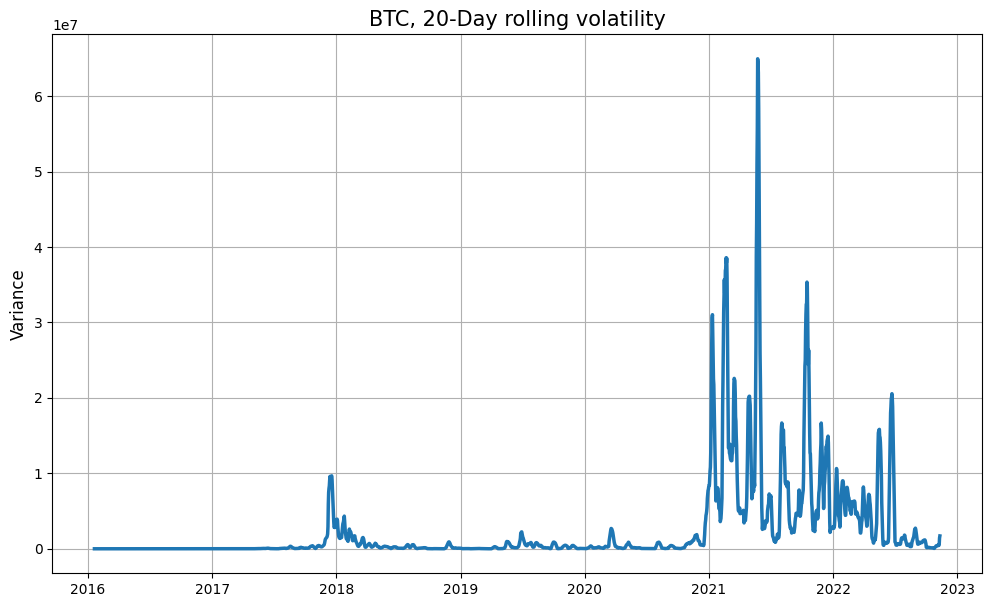

In [18]:
plt.figure(figsize=(12, 7))
plt.plot(BTC.Var_20.iloc[19:],linewidth=2.5)
plt.ylabel('Variance',fontsize=12)
plt.grid(True)
plt.title('BTC, 20-Day rolling volatility',fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [19]:
VAR5 = BTC['Var_5'][BTC.Var_5>0]
VAR10 = BTC['Var_10'][BTC.Var_10>0]
VAR20 = BTC['Var_20'][BTC.Var_20>0]

CI5 = [np.quantile(VAR5,0.025),np.quantile(VAR5,0.975)]
CI10 = [np.quantile(VAR10,0.025),np.quantile(VAR10,0.975)]
CI20 = [np.quantile(VAR20,0.025),np.quantile(VAR20,0.975)]

CHG_DATES = dates_star.Dates
n = len(dates_star)

VAR_DATA = pd.DataFrame(index=CHG_DATES,columns=['VAR5_after','in CI5','VAR10_after','in CI10','VAR20_after','in CI20'])

for d in CHG_DATES:
    period5 = after(BTC['Adj Close'],d,5)
    VAR_DATA.loc[d,'VAR5_after'] = period5.var()
    if period5.var() < CI5[1] and period5.var() > CI5[0]:
        VAR_DATA.loc[d,'in CI5'] = 1
    else:
        VAR_DATA.loc[d,'in CI5'] = 0
        
    period10 = after(BTC['Adj Close'],d,10)
    VAR_DATA.loc[d,'VAR10_after'] = period10.var()
    if period10.var() < CI10[1] and period10.var() > CI10[0]:
        VAR_DATA.loc[d,'in CI10'] = 1
    else:
        VAR_DATA.loc[d,'in CI10'] = 0
        
    period20 = after(BTC['Adj Close'],d,20)
    VAR_DATA.loc[d,'VAR20_after'] = period20.var()
    if period20.var() < CI20[1] and period20.var() > CI20[0]:
        VAR_DATA.loc[d,'in CI20'] = 1
    else:
        VAR_DATA.loc[d,'in CI20'] = 0

In [20]:
VAR_DATA

,VAR5_after,in CI5,VAR10_after,in CI10,VAR20_after,in CI20
Dates,,,,,,
2016-12-15,58.750094,1,2879.669478,1,10397.684674,1
2017-03-16,5495.71324,1,5703.058677,1,4116.181404,1
2017-06-15,8799.639434,1,8087.161396,1,7507.299209,1
2017-12-14,1288588.174302,1,4245129.582345,1,3778943.779779,1
2018-03-22,149627.284361,1,621939.447815,1,565757.492811,1
2018-06-14,16939.461256,1,68529.378798,1,68476.344889,1
2018-09-27,1810.735547,1,2119.788153,1,18416.283988,1
2018-12-20,13713.123487,1,18449.896161,1,15011.341996,1
2019-05-02,15027.730026,1,290444.597882,1,970608.063608,1


Similar results - there appears to be so signifigant changes in the volatility after a change in the FED rate. 

Again, the same issue as before. The volatility is going to be a lot greater due to the massive increase in scale of the price of BTC over the past few years. It again might make more sense to look at how the rolling var changes relativley - i.e (var_after/var_before) -- is this value signifgantly different from 1?

Another measurement I chose to look at was the daily change. That is the high minus the low for the day. This is also a measure of volatility.

The idea here is for each date we look at the daily range for several days after and compare these values to the standard daily range for BTC.

In [23]:
# Get change values for the FED rate as well:
FED_CHG = abs(FED.diff(1))

In [26]:
CHG_DATES = dates_star.Dates
n = len(dates_star)

BTC['Range'] = BTC.High - BTC.Low #gets the range at each date

RNG_DATA = pd.DataFrame(index=CHG_DATES,columns=['0','1','2','3','4','5'])

for d in CHG_DATES:
    rng = after(BTC.Range,d,5)
    RNG_DATA.loc[d] = list(rng)

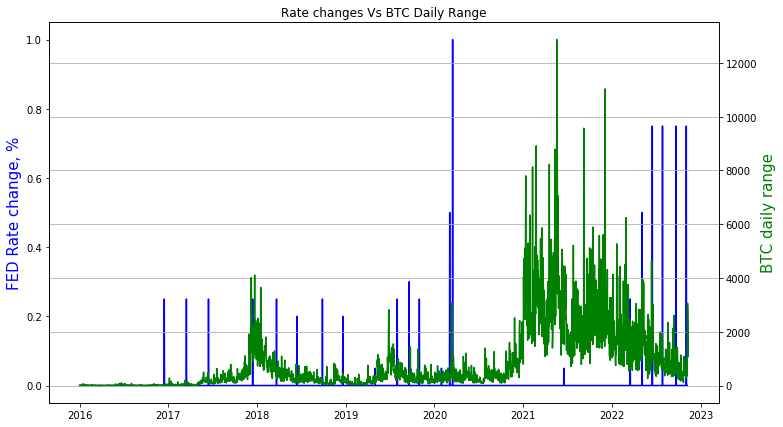

In [32]:
fig, ax1 = plt.subplots(figsize=(12, 7))
ax2 = ax1.twinx()
           
ax1.plot(FED_CHG,color='b')
ax2.plot(BTC.Range,linewidth=1.5,color='g')
ax1.set_ylabel('FED Rate change, %', color='b',fontsize=15)
ax2.set_ylabel('BTC daily range', color='g',fontsize=15)

plt.grid(True)
plt.title('Rate changes Vs BTC Daily Range')
plt.xticks(fontsize=10)

plt.show()

Get an idea of the distribution of the daily range

In [23]:
RNG_DATA

,0,1,2,3,4,5
Dates,,,,,,
2016-12-15,3.632996,6.068969,7.644958,6.710999,3.291016,9.839966
2017-03-16,105.540039,80.590088,156.414917,93.180054,26.349975,67.070069
2017-06-15,321.75,154.77002,200.22998,145.77002,113.820069,173.629883
2017-12-14,899.90039,1552.798828,2201.398438,1114.900391,1015.099609,1902.40039
2018-03-22,535.80957,519.0,330.479493,232.910157,608.649902,435.500488
2018-06-14,372.680176,247.209961,190.200195,89.839843,334.459961,112.580078
2018-09-27,247.149903,186.709961,131.450196,77.239746,104.219727,73.939942
2018-12-20,462.253907,347.483399,158.443603,109.317871,271.460693,329.541015
2019-05-02,128.04541,375.680176,241.424317,125.827637,149.27002,246.782227


In [24]:
upr = np.quantile(BTC.Range,0.975) #upr is the upper quantile for the daily range, 95%

RNG_DATA > upr #chcek where the upper qunatile is exceeded

,0,1,2,3,4,5
Dates,,,,,,
2016-12-15,False,False,False,False,False,False
2017-03-16,False,False,False,False,False,False
2017-06-15,False,False,False,False,False,False
2017-12-14,False,False,False,False,False,False
2018-03-22,False,False,False,False,False,False
2018-06-14,False,False,False,False,False,False
2018-09-27,False,False,False,False,False,False
2018-12-20,False,False,False,False,False,False
2019-05-02,False,False,False,False,False,False


We do see some signifgant values but it's only two and they are after one another, this is probably due to just a turbulent period unrelated to the FED rate.

Some issues with analysis:
 - The value of BTC has changed greatly over this period. The value in the last few years is signifigantly greater than that in the earlier dates. This makes a comparison like this quite hard.  
 - The small ranges at the start and large ranges towards the end will create a very skewed distribution for the daily ranges

In the above it may make sense to look at a MA of the ranges as hey are highly sensitive to changes in the BTC price and thus there would be a lot of other random noise in these measurements